In [5]:
from __future__ import print_function
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

CAR_RATE = 3 # velocity of the car
TIME_CONST = 10000 #zoom in the time
RESOLUTION = 0.1

In [44]:
class Road:
    def __init__(self, city, numOfCell=10, introRate=2, remvRate=2, carRate = 2, direction = (0,1), startPos = (0,0),interval =0.001,totalTime = 1000,name=''):
        #int numOfCell, int introRate, int remvRate, int index
        self.__introRate = introRate
        self.__remvRate = remvRate
        self.carRate = carRate
        self.allCars = [] #cars in this road
        self.numOfCell = numOfCell
        self.passCar = 0 # number of the passing cars
        self.conflict = 0
        self.direction = direction
        self.startPos = startPos
        self.endPos = (startPos[0]+self.direction[0]*(self.numOfCell-1), startPos[1]+self.direction[1]*(self.numOfCell-1))
        #self.cell = {}  #cells in this road
        self.city = city
        self.time_sum_car = 0
        self.density = 0
        self.J = 0
        self.interval = interval
        self.totalTime = totalTime
        self.name = name
        for i in range(self.numOfCell):
            self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] = 1
        
    def introCar(self):
        # introduce a new car to this road
        if ((random.random() < self.__introRate*self.interval) &(self.city.map[self.startPos] == 1)):
            self.city.map[self.startPos] = 2
            newCar = Car(self, interval = self.interval,expClockRate= self.carRate)
            self.allCars.insert(0, newCar)
            
    def remvCar(self):
        # remove the car in the last cell of this road
        if ((random.random() < self.__remvRate*self.interval)&(self.city.map[self.endPos] == 2)):
            self.city.map[self.endPos] = 1
            self.allCars.pop()
            self.passCar += 1
            
    def showCar(self):
        for i in range(self.numOfCell):
            if self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] == 1:
                print(" | "+" ",end="")
            else:
                print(" | "+"*",end="")
        print(" |\n")
    def calculateRate(self):
        self.density = self.time_sum_car/(self.totalTime/self.interval*self.numOfCell)
        self.J = self.passCar / self.totalTime
        

        

In [45]:
class Car:
    def __init__(self, road, position=0, expClockRate=3, prob=0.5,interval =0.001):
        #int position, int expClockRate, float prob, int index (which road)
        self.__position = (road.startPos[0]+road.direction[0]*position, road.startPos[1]+road.direction[1]*position)
        self.__expClockRate = expClockRate
        self.__prob = prob
        self.__road = road
        self.interval = interval
    def moveForward(self):
        if (random.random() < self.__expClockRate*self.interval)&(random.random() < self.__prob):
            # expo & not broken
            if (self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 1): # next cell is empty
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])
                self.__road.city.map[self.__position] = 2
            else:
                return "conflict"
        return "move"

In [46]:
class City:
    def __init__(self, l=100, w=100,totalTime = 1000,interval = 0.001,name='Berkeley'):
        self.l = l
        self.w = w
        self.map = {(i,j):0 for i in range(self.l) for j in range(self.w)} 
        self.roads=[]
        self.totalTime = totalTime
        self.interval = interval
        self.name =name
    def showCity(self):
        rx = []
        ry = []
        cx = []
        cy = []
        for i in Berkeley.map:
            if Berkeley.map[i] != 0:
                rx.append(i[0])
                ry.append(i[1])
            if Berkeley.map[i] == 2:
                cx.append(i[0])
                cy.append(i[1])
        plt.plot(rx, ry, "o")
        plt.plot(cx, cy, "*")
        plt.show()
    def createRoad(self,numOfCell=10, introRate=2, remvRate=2,carRate = 2, direction = (0,1), startPos = (0,0),name = ''):
        newRoad = Road(self, numOfCell=numOfCell, introRate=introRate, remvRate=remvRate, direction = direction, \
                       startPos = startPos,interval = self.interval,totalTime = self.totalTime, name = name)
        self.roads.append(newRoad)
    def introCar(self):
        for road in self.roads:
            road.introCar()
            
    def remvCar(self):
        for road in self.roads:
            road.remvCar()
    def moveCar(self):
        for road in self.roads:
            for car in road.allCars:
                ret = car.moveForward()
                if ret =="conflict":
                    road.conflict += 1
    def time_sum_car(self):
        for road in self.roads:
            road.time_sum_car += len(road.allCars)
    def calculateRate(self):
        for road in self.roads:
            road.calculateRate()
    def freshMap(self):
        del(self.roads[:])
        self.roads=[]
        self.map = {(i,j):0 for i in range(self.l) for j in range(self.w)} 

In [47]:
# startTime = 0
# lastTime = startTime
# Stop = False")
# currentTime = startTime - interval
# while not Stop:
#     currentTime = currentTime+interval
#     if currentTime > TOTAL_TIME:
#         Stop = True
#     Berkeley.introCar()
#     Berkeley.remvCar()
#     Berkeley.moveCar()
#     Berkeley.time_sum_car()
# Berkeley.calculateRate()

In [51]:
fig = plt.figure()
TOTAL_TIME = 1000
interval = 0.001
SF = City(totalTime=TOTAL_TIME, interval= interval, name = 'SF')
x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
j = []
d = []
for ir in x:
    jj = []
    dd = []
    for rr in y:
        SF.freshMap()
        SF.createRoad(introRate=ir, remvRate=rr)
        startTime = 0
        Stop = False
        currentTime = startTime - interval
        while not Stop:
            currentTime = currentTime+interval
            if currentTime > TOTAL_TIME:
                Stop = True
            SF.introCar()
            SF.remvCar()
            SF.moveCar()
            SF.time_sum_car()
        SF.calculateRate()
        jj.append(SF.roads[0].J)
        dd.append(SF.roads[0].density)
    j.append(jj)
    d.append(dd)

<Figure size 432x288 with 0 Axes>

<function matplotlib.pyplot.show>

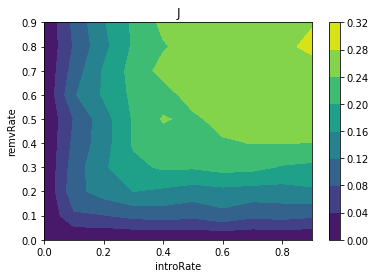

In [60]:
array_z = np.array(j)
array_x,array_y = np.meshgrid(x,y)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("J")
plt.colorbar()
plt.show



<function matplotlib.pyplot.show>

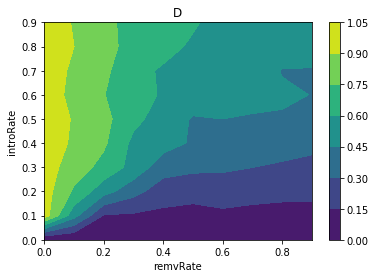

In [64]:
array_z = np.array(d)
array_x,array_y = np.meshgrid(y,x)
surf = plt.contourf(array_x,array_y,array_z)
plt.xlabel('remvRate')
plt.ylabel('introRate')
plt.title("D")
plt.colorbar()
plt.show

In [63]:
print (z)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 78, 96, 99, 92, 91, 81, 90, 99, 95], [0, 109, 149, 168, 173, 160, 150, 187, 171, 159], [0, 97, 160, 218, 224, 228, 240, 249, 264, 237], [0, 85, 159, 237, 266, 289, 274, 275, 281, 297], [0, 85, 156, 243, 272, 301, 324, 314, 341, 320], [0, 91, 182, 232, 285, 327, 356, 350, 355, 357], [0, 103, 172, 250, 268, 298, 353, 355, 375, 368], [0, 70, 167, 231, 267, 292, 365, 378, 375, 389], [0, 94, 167, 253, 281, 304, 351, 380, 370, 399]]


In [56]:
bk = City(totalTime=TOTAL_TIME, interval= interval)
bk.createRoad(introRate=1, remvRate=0.1)
startTime = 0
Stop = False
currentTime = startTime - interval
while not Stop:
    currentTime = currentTime+interval
    if currentTime > TOTAL_TIME:
        Stop = True
    bk.introCar()
    bk.remvCar()
    bk.moveCar()
    bk.time_sum_car()
bk.calculateRate()

In [57]:
bk.roads[0].density

0.8926585

In [58]:
y = np.arange(0, 1, 0.1)

In [44]:
def test():
    carRate = widgets.FloatSlider(min=0.1, max=5.0, step=0.1, description='carRate: ')
    carMoveProb = widgets.FloatSlider(min=0.0, max=1.0,step =0.001, description='moveProb:')
    
    numOfCell = widgets.IntSlider(min=10, max=100, step=1, description='numOfCell: ')
    introRate = widgets.FloatSlider(min=0.1, max=5.0, step=0.1, description='introRate: ')
    remvRate = widgets.FloatSlider(min=0.1, max=5.0, step=0.1, description='remvRate: ')
    
    ui = widgets.VBox([carRate, carMoveProb, numOfCell, introRate, remvRate])
    
    def f(carRate, carMoveProb, numOfCell, introRate, remvRate):
        print('Now on our roads: \n'+' The cars move at a speed of '+str(carRate),'\n', 'The probability that each of the cars move is '+str(carMoveProb)+'\n', 'At the same time, there are '+str(numOfCell)+' cars at most on our roads.\n', 'The cars go into the roads at a rate of '+str(introRate)+'\n', 'The cars leave the roads at a rate of '+str(remvRate)+'\n')
        return(carRate, carMoveProb, numOfCell, introRate, remvRate)
    
    out = widgets.interactive_output(f, {'remvRate': remvRate, 'introRate': introRate, 'numOfCell': numOfCell, 'carMoveProb':carMoveProb , 'carRate': carRate})
    
    print('Please use the sliders below to adjust the parameters. They are: carRate, carMoveProb, numOfCell, introRate, remvRate')
    
    display(ui, out)
    
    print(carRate.value)
    
test()

Please use the sliders below to adjust the parameters. They are: carRate, carMoveProb, numOfCell, introRate, remvRate


Output()

0.1
